## Разведочный анализ данных

# Подготовка и первичная проверка данных

In [1]:
import pandas as pd

df = pd.read_parquet("transaction_fraud_data.parquet")
rates = pd.read_parquet("historical_currency_exchange.parquet")

print("Транзакции:", df.shape)
print("Курсы валют:", rates.shape)

print(df.dtypes)
print(df.isna().sum())

print("Дубликаты transaction_id:", df["transaction_id"].duplicated().sum())

print("Мин сумма:", df["amount"].min(), "Макс сумма:", df["amount"].max())


print("Валюты:", df["currency"].unique())
print("Категории вендоров:", df["vendor_category"].unique()[:10])

Транзакции: (7483766, 23)
Курсы валют: (31, 12)
transaction_id                     object
customer_id                        object
card_number                         int64
timestamp                  datetime64[us]
vendor_category                    object
vendor_type                        object
vendor                             object
amount                            float64
currency                           object
country                            object
city                               object
city_size                          object
card_type                          object
is_card_present                      bool
device                             object
channel                            object
device_fingerprint                 object
ip_address                         object
is_outside_home_country              bool
is_high_risk_vendor                  bool
is_weekend                           bool
last_hour_activity                 object
is_fraud                    

# Преобразование данных в нужный формат. Приведение даты и времени к стандартному формату и всех цен к долларам США

In [6]:
rates["date"] = pd.to_datetime(rates["date"])
df["date"] = df["timestamp"].dt.date
df["date"] = pd.to_datetime(df["date"])

merged = df.merge(rates, on="date", how="left")

for cur in rates.columns:
    if cur not in ["date", "USD"]:  
        merged.loc[merged["currency"] == cur, "amount_usd"] = (
            merged.loc[merged["currency"] == cur, "amount"] / merged.loc[merged["currency"] == cur, cur]
        )

merged.loc[merged["currency"] == "USD", "amount_usd"] = merged.loc[merged["currency"] == "USD", "amount"]

In [4]:
print("Количество непересчитанных значений:", merged["amount_usd"].isna().sum())
print("Пример:", merged[["amount", "currency", "amount_usd"]].head(10))

Количество непересчитанных значений: 0
Пример:       amount currency   amount_usd
0     294.87      GBP   394.658011
1    3368.97      BRL   619.905757
2  102582.38      JPY   719.506409
3     630.60      AUD   436.808287
4  724949.27      NGN   434.430069
5      11.76      BRL     2.163893
6    2606.19      BRL   479.550778
7     828.33      EUR   924.897854
8  104921.00      NGN    62.874520
9   51521.84      MXN  2616.022485


## Удаление дубликатов

In [7]:
dup_count = merged.duplicated(subset=["transaction_id"]).sum()
print(f"Количество дубликатов: {dup_count}")

merged = merged.drop_duplicates(subset=["transaction_id"], keep="first")

print(f"Размер датасета после удаления дубликатов: {len(merged)}")

Количество дубликатов: 6460
Размер датасета после удаления дубликатов: 7477306


# Описательный анализ 

In [8]:
summary_stats = merged["amount_usd"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])

print("📊 Общая статистика по транзакциям (в USD):")
print(summary_stats)

top_transactions = merged.nlargest(10, "amount_usd")[["transaction_id", "amount_usd", "currency", "vendor_category"]]
print("\n🔝 Топ-10 крупнейших транзакций:")
print(top_transactions)

📊 Общая статистика по транзакциям (в USD):
count    7.477306e+06
mean     5.426419e+02
std      7.284015e+02
min      2.406185e-03
25%      1.686306e+02
50%      3.592634e+02
75%      6.155422e+02
90%      1.273015e+03
99%      2.886115e+03
max      1.578154e+04
Name: amount_usd, dtype: float64

🔝 Топ-10 крупнейших транзакций:
        transaction_id    amount_usd currency vendor_category
2931774    TX_33de8275  15781.540993      MXN          Travel
1730096    TX_e4a38519  15757.587128      MXN          Travel
1953489    TX_14d04f46  15720.078490      MXN          Travel
208083     TX_8a13a5a6  15693.767745      SGD          Travel
3402759    TX_33105936  15682.188327      SGD          Travel
4116687    TX_52d49192  15668.539655      SGD          Travel
3482562    TX_3e010d82  15641.360167      MXN          Travel
3165906    TX_ef261221  15640.579675      SGD          Travel
2184804    TX_684fe19a  15634.910798      MXN          Travel
1800272    TX_14459b5d  15609.087610      MXN      

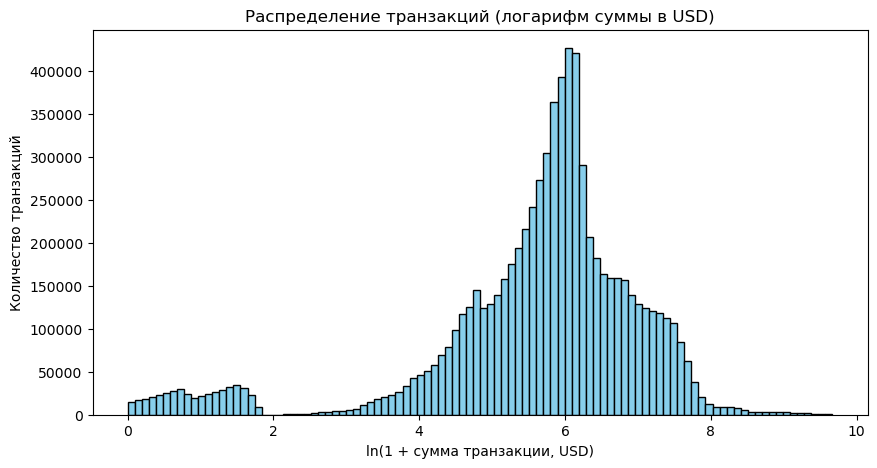

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
plt.hist(np.log1p(merged["amount_usd"]), bins=100, color="skyblue", edgecolor="black")
plt.title("Распределение транзакций (логарифм суммы в USD)")
plt.xlabel("ln(1 + сумма транзакции, USD)")
plt.ylabel("Количество транзакций")
plt.show()

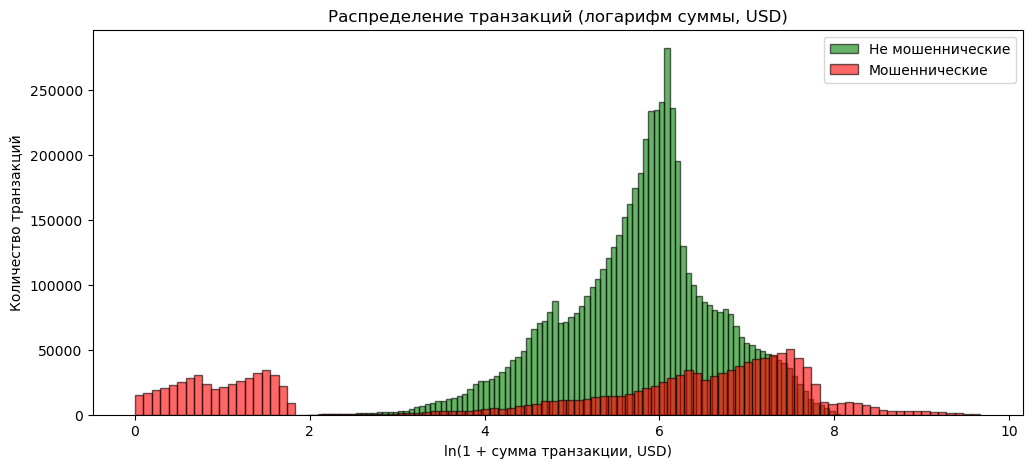

In [21]:
plt.figure(figsize=(12,5))

plt.hist(np.log1p(merged.loc[~merged["is_fraud"], "amount_usd"]), 
         bins=100, color="green", alpha=0.6, label="Не мошеннические", edgecolor="black")

plt.hist(np.log1p(merged.loc[merged["is_fraud"], "amount_usd"]), 
         bins=100, color="red", alpha=0.6, label="Мошеннические", edgecolor="black")

plt.title("Распределение транзакций (логарифм суммы, USD)")
plt.xlabel("ln(1 + сумма транзакции, USD)")
plt.ylabel("Количество транзакций")
plt.legend()
plt.show()

In [24]:
vendor_counts = merged["vendor_category"].value_counts()

counts_by_vendor = merged.groupby(["vendor_category", "is_fraud"])["transaction_id"].count().unstack(fill_value=0)


avg_amount_by_vendor = merged.groupby("vendor_category")["amount_usd"].mean().sort_values(ascending=False)

median_amount_by_vendor = merged.groupby("vendor_category")["amount_usd"].median().sort_values(ascending=False)

vendor_stats = pd.DataFrame({
    "Средний чек": avg_amount_by_vendor,
    "Медианный чек": median_amount_by_vendor
}).sort_values("Средний чек", ascending=False)

fraud_stats = merged.groupby("is_fraud")["amount_usd"].agg(["mean", "median"])


print("🔹 Количество транзакций по категориям:")
print(vendor_counts)

print("📊 Количество транзакций по категориям (честные vs мошеннические):")
print(counts_by_vendor)

print(vendor_stats)

print("📊 Средний и медианный чек (USD) для fraud / non-fraud:")
print(fraud_stats)

🔹 Количество транзакций по категориям:
vendor_category
Healthcare       935976
Entertainment    935398
Restaurant       935354
Retail           935061
Travel           935010
Gas              934539
Grocery          933191
Education        932777
Name: count, dtype: int64
📊 Количество транзакций по категориям (честные vs мошеннические):
is_fraud          False   True 
vendor_category                
Education        746721  186056
Entertainment    748646  186752
Gas              747874  186665
Grocery          746398  186793
Healthcare       749352  186624
Restaurant       748579  186775
Retail           748610  186451
Travel           747680  187330
                 Средний чек  Медианный чек
vendor_category                            
Travel           1040.816500     597.807162
Retail            667.324427     466.370872
Healthcare        514.918706     394.734016
Education         514.490233     393.652802
Gas               513.255009     393.725440
Grocery           416.526413     

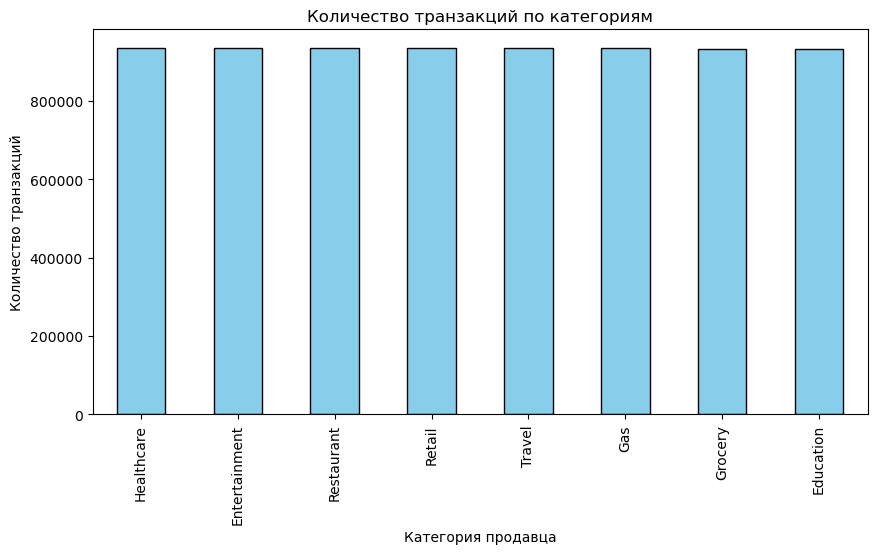

In [12]:
plt.figure(figsize=(10,5))
vendor_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Количество транзакций по категориям")
plt.xlabel("Категория продавца")
plt.ylabel("Количество транзакций")
plt.show()

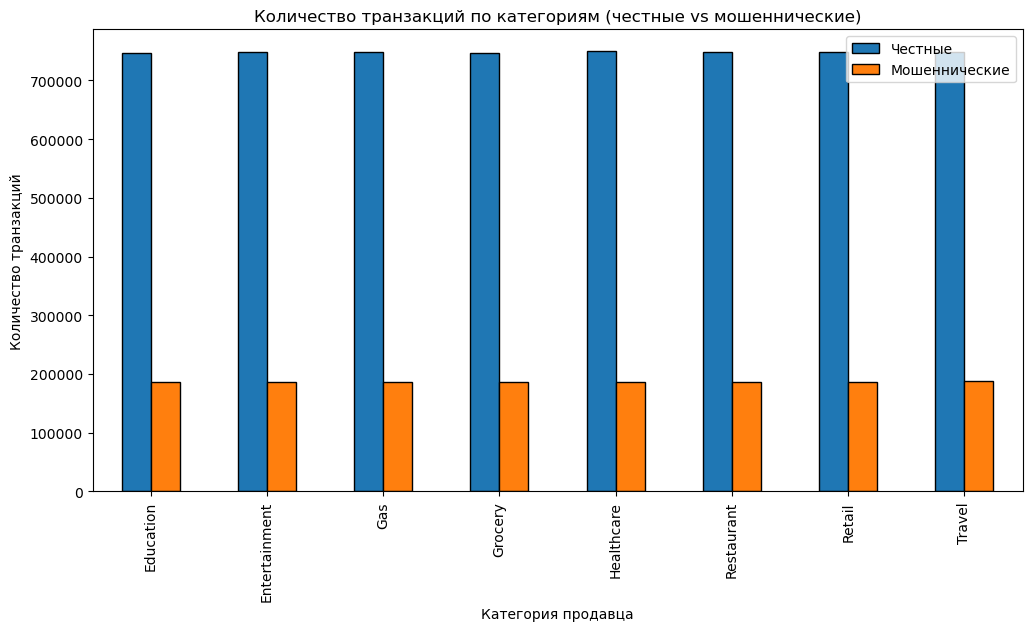

In [25]:
counts_by_vendor.plot(kind="bar", figsize=(12,6), edgecolor="black")
plt.title("Количество транзакций по категориям (честные vs мошеннические)")
plt.xlabel("Категория продавца")
plt.ylabel("Количество транзакций")
plt.legend(["Честные", "Мошеннические"])
plt.show()

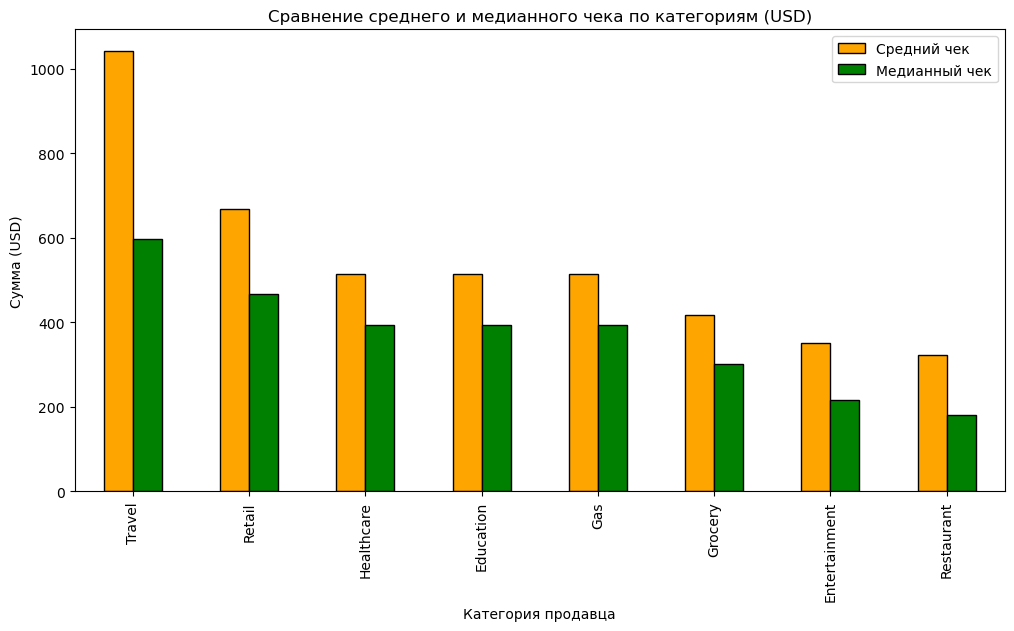

In [19]:
vendor_stats.plot(kind="bar", figsize=(12,6), color=["orange", "green"], edgecolor="black")
plt.title("Сравнение среднего и медианного чека по категориям (USD)")
plt.xlabel("Категория продавца")
plt.ylabel("Сумма (USD)")
plt.legend()
plt.show()

C:\Users\kormy\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\kormy\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


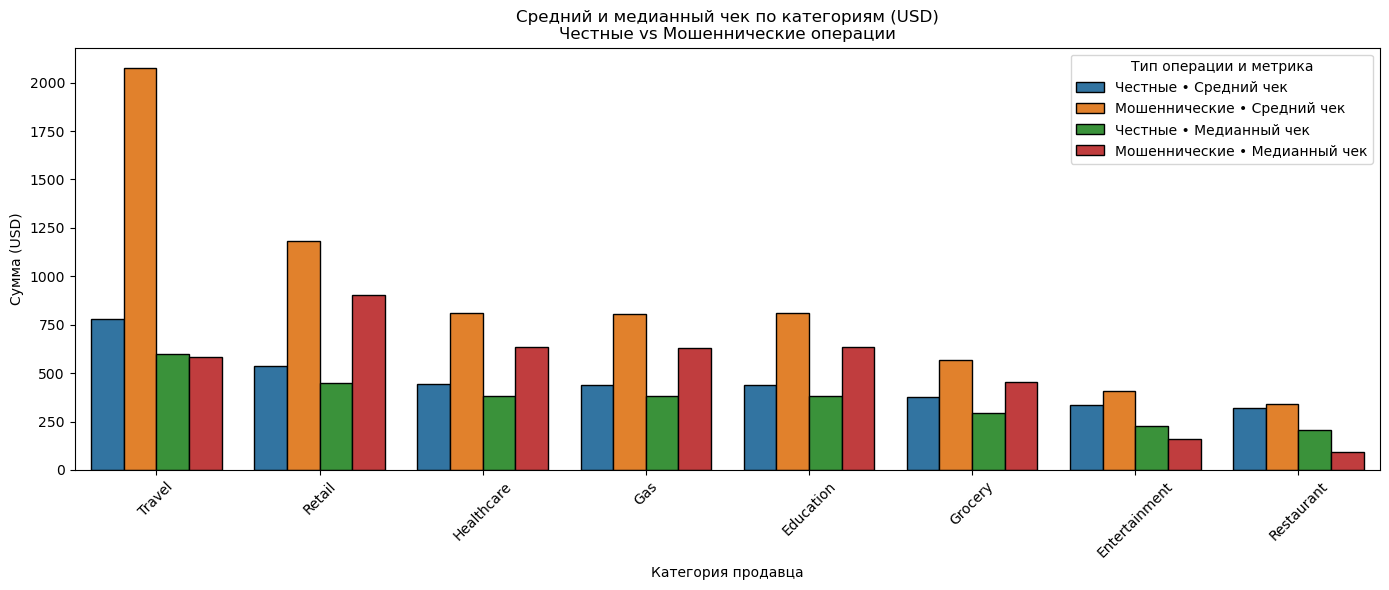

In [27]:
agg = (merged
       .groupby(["vendor_category", "is_fraud"])["amount_usd"]
       .agg(mean="mean", median="median")
       .reset_index())

# переводим в длинный формат (чтобы было удобно строить график)
agg_long = agg.melt(id_vars=["vendor_category", "is_fraud"],
                    value_vars=["mean", "median"],
                    var_name="metric",
                    value_name="amount_usd")

# добавим подписи
agg_long["fraud_label"] = agg_long["is_fraud"].map({False: "Честные", True: "Мошеннические"})
agg_long["metric_label"] = agg_long["metric"].map({"mean": "Средний чек", "median": "Медианный чек"})
agg_long["group"] = agg_long["fraud_label"] + " • " + agg_long["metric_label"]

# сортируем категории по медианному чеку честных
order = (agg_long[(agg_long["fraud_label"] == "Честные") & (agg_long["metric"] == "median")]
         .sort_values("amount_usd", ascending=False)["vendor_category"].tolist())
agg_long["vendor_category"] = pd.Categorical(agg_long["vendor_category"], categories=order, ordered=True)

# строим график
plt.figure(figsize=(14,6))
import seaborn as sns
sns.barplot(data=agg_long, 
            x="vendor_category", 
            y="amount_usd", 
            hue="group", 
            edgecolor="black")

plt.title("Средний и медианный чек по категориям (USD)\nЧестные vs Мошеннические операции")
plt.xlabel("Категория продавца")
plt.ylabel("Сумма (USD)")
plt.legend(title="Тип операции и метрика")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ по геопозиции

In [31]:
country_counts = (merged
    .groupby(["country", "is_fraud"])["transaction_id"]
    .count()
    .reset_index())


top_countries = (country_counts
                 .groupby("country")["transaction_id"]
                 .sum()
                 .nlargest(10)
                 .index)

country_counts_top = country_counts[country_counts["country"].isin(top_countries)]


pivot_top = (country_counts_top
             .pivot(index="country", columns="is_fraud", values="transaction_id")
             .fillna(0)
             .rename(columns={False: "Честные", True: "Мошеннические"}))


pivot_top = pivot_top.loc[pivot_top.sum(axis=1).sort_values(ascending=False).index]

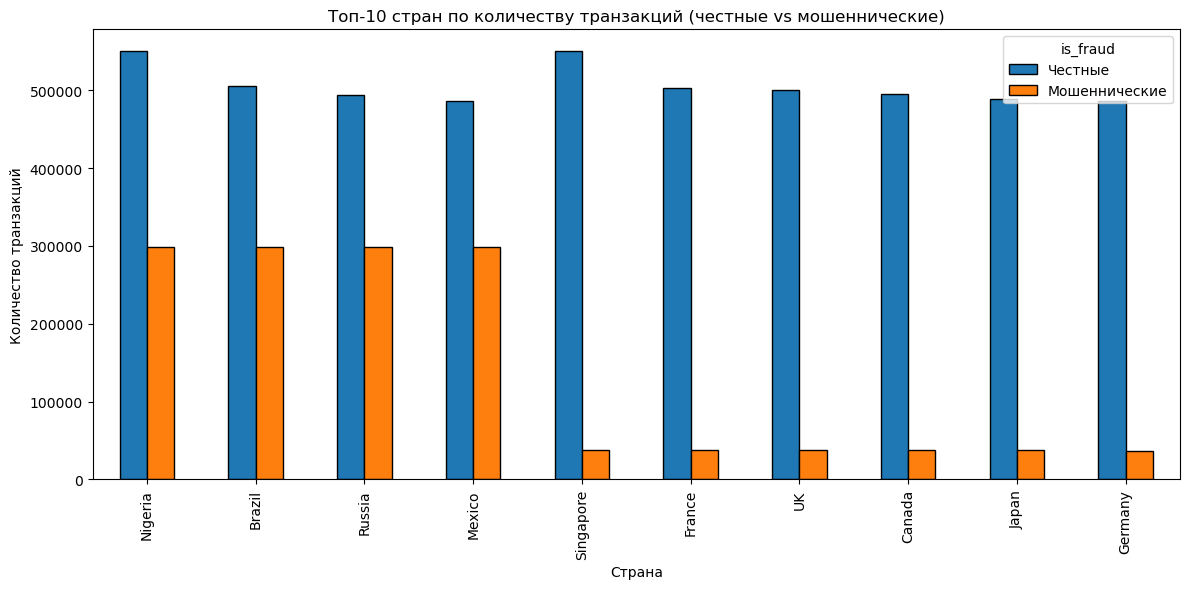

In [32]:
ax = pivot_top.plot(kind="bar", figsize=(12,6), edgecolor="black")
ax.set_title("Топ-10 стран по количеству транзакций (честные vs мошеннические)")
ax.set_xlabel("Страна")
ax.set_ylabel("Количество транзакций")
plt.tight_layout()
plt.show()

In [34]:
fraud_share = (country_counts
               .pivot(index="country", columns="is_fraud", values="transaction_id")
               .fillna(0)
               .rename(columns={False: "ok", True: "fraud"}))

fraud_share["fraud_pct"] = fraud_share["fraud"] / (fraud_share["ok"] + fraud_share["fraud"]) * 100

top_share = fraud_share.sort_values("fraud_pct", ascending=False).head(10)


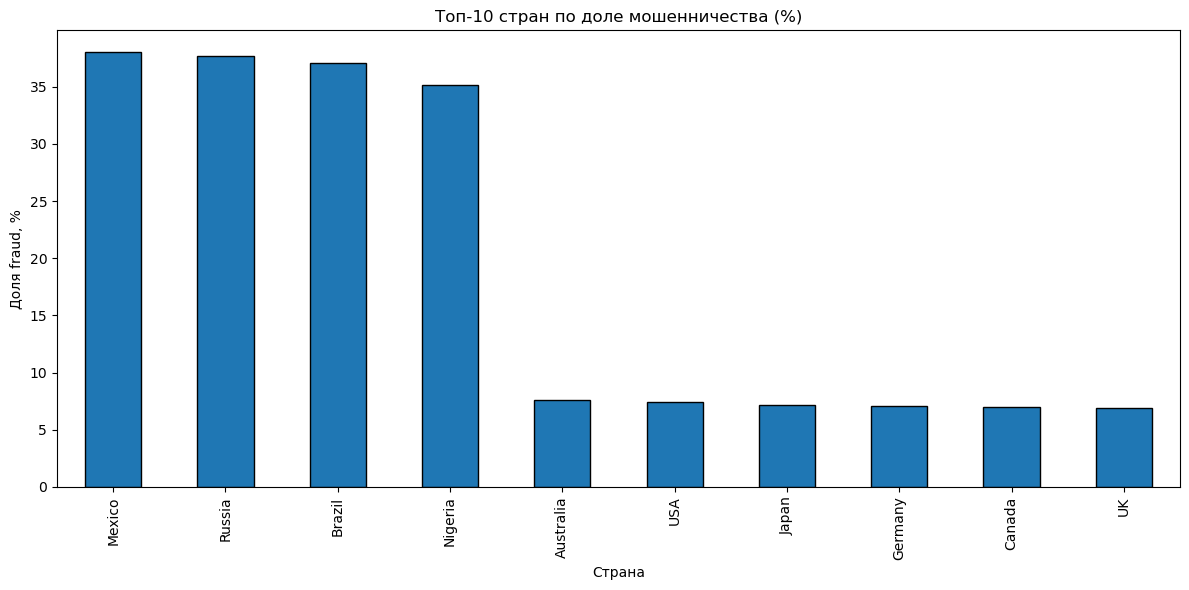

In [35]:
ax = top_share["fraud_pct"].plot(kind="bar", figsize=(12,6), edgecolor="black")
ax.set_title("Топ-10 стран по доле мошенничества (%)")
ax.set_xlabel("Страна")
ax.set_ylabel("Доля fraud, %")
plt.tight_layout()
plt.show()